***TASK 6 - Sourcing & Analyzing Time Series Data***

***Table of Content***

1. Importing Libraries & Options
2. Importing Dataframe
3. Checking the Data
4. Preparing the Data
5. Creating a Line Chart
6. Decomposing the Data
7. Testing for Stationarity
8. Stationarizing the Data
9. Stationarizing the Data (second round)

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!pwd

import os
os.chdir('/content/drive/MyDrive/airbnb-data-analysis/code')

!pwd

Mounted at /content/drive/
/content
/content/drive/MyDrive/airbnb-data-analysis/code


***1. Importing Libraries & Options***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
# Prompting matplotlib visuals to appear in the notebook 

%matplotlib inline

In [4]:
# Removing the max column cap
pd.options.display.max_columns = None

***2. Importing Dataframe***

In [5]:
# Importing dataframe

df = pd.read_csv('listings_clean.csv', index_col = False)

***3. Checking the Data***

In [7]:
df.drop('review_category', axis=1, inplace=True)

In [6]:
# 45 columns, but I will only need 2 to create my map

df.shape

(5266, 46)

In [8]:
df.head()

,id,host_id,host_since,host_response_time,host_resp_rate_pct,host_accept_rate_pct,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price_usd,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,144978,216682,2010-08-29,within a few hours,100,89,f,9,t,t,Pacific Heights,37.79233,-122.42431,Private room in rental unit,Private room,1,Unknown,1.0,1.0,55.0,30,365,t,7,24,54,54,120,0,0,2011-07-10,2020-03-31,4.68,4.78,4.45,4.86,4.81,4.81,4.66,f,9,4,5,0,0.86
1,958,1169,2008-07-31,within an hour,100,98,t,1,t,t,Western Addition,37.77028,-122.43317,Entire serviced apartment,Entire home/apt,3,1 bath,1.0,2.0,194.0,2,30,t,1,15,35,161,371,57,2,2009-07-23,2022-11-18,4.86,4.93,4.92,4.95,4.88,4.98,4.76,f,1,1,0,0,2.28
2,5858,8904,2009-03-02,within a few hours,80,71,f,2,t,t,Bernal Heights,37.74474,-122.42089,Entire rental unit,Entire home/apt,4,1 bath,2.0,2.0,235.0,30,60,t,30,60,90,365,111,0,0,2009-05-03,2017-08-06,4.88,4.85,4.87,4.89,4.85,4.77,4.68,f,1,1,0,0,0.67
3,8142,21994,2009-06-17,within a few hours,100,74,f,12,t,t,Haight Ashbury,37.76555,-122.45213,Private room in rental unit,Private room,1,4 shared baths,1.0,1.0,56.0,32,90,t,30,60,90,365,9,1,0,2014-09-08,2022-10-27,4.67,4.44,4.44,4.78,4.78,4.67,4.67,f,12,0,12,0,0.09
4,8739,7149,2009-01-27,within an hour,100,89,t,2,t,t,Mission,37.76030,-122.42197,Private room in condo,Private room,3,1 private bath,1.0,1.0,129.0,1,26,t,15,41,71,161,761,25,1,2009-08-01,2022-11-18,4.91,4.94,4.94,4.95,4.96,4.93,4.74,f,2,0,2,0,4.68


In [9]:
df.host_since.min()

'2008-07-31'

In [10]:
df.host_since.max()

'2022-11-11'

# ***COMMENT***

I would like to perform a time-series on host subscriptions to Airbnb in London.

The dataframe I am using lists "host_since", which means I can find out (count) how many people signed-up to be hosts on each day since 31th July 2008 and until 29th November 2022. I believe it would be interesting to explore the evolution of the platform, the number of hosts signing up to Airbnb is a key metric of the platforms popularity, since they take a fee on each rentals.

First I need to remove duplicates (through 'host_id'), then I'll be able to have a quick look at unique sign-up rates through 'host_since'

One caveat is that there hasn't been a new host signing up everyday, therefore my timeline has missing dates. To remedy this problem, I will create a new csv file with all the dates and I will merge it with my dataframe, to then be able to perform my timeseries analysis.

***4. Preparing the Data***

***STEP 1:***

***(removing duplicates)***

In [11]:
# Removing all duplicates from the 'host_id' column

df_no_dups = df.drop_duplicates(subset=['host_id'])

In [12]:
# Checking the result of my query

df_no_dups.shape

(2964, 45)

***STEP 2:***

***(quick look at the data)***

In [13]:
# Looking at the variable I am interested in analysing 
# indexed so I can see the head and the tail of the data (first & last dates).

df_no_dups['host_since'].value_counts().sort_index()

2008-07-31    1
2009-01-27    1
2009-03-02    1
2009-03-13    1
2009-04-12    1
             ..
2022-11-03    1
2022-11-06    1
2022-11-07    1
2022-11-08    2
2022-11-11    1
Name: host_since, Length: 2017, dtype: int64

In [14]:
# Converting variable to date format

df_no_dups['host_since'] = pd.to_datetime(df_no_dups['host_since'])

In [15]:
df_no_dups['host_since'].dtype

dtype('<M8[ns]')

<Axes: >

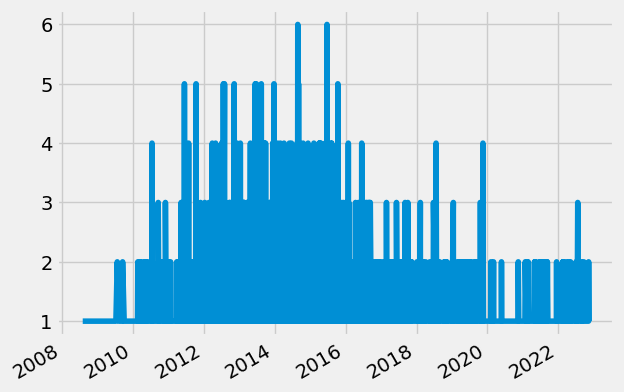

In [16]:
# Having a quick look at the data through a line plot
# I don't see any outliers as such
df_no_dups['host_since'].value_counts().plot.line()

In [17]:
df_no_dups['host_since'].value_counts()

2014-08-25    6
2015-06-22    6
2011-10-12    5
2014-09-02    5
2012-11-08    5
             ..
2017-04-28    1
2017-08-31    1
2017-04-24    1
2017-09-09    1
2012-05-19    1
Name: host_since, Length: 2017, dtype: int64

***STEP 3:***

***(creating a subset for my timeseries)***

In [18]:
# Preparing the modified original dataframe for timeseries analysis
# Extracting the two columns I will need into a subset

data = df_no_dups['host_since'].value_counts().sort_index()

In [19]:
data

2008-07-31    1
2009-01-27    1
2009-03-02    1
2009-03-13    1
2009-04-12    1
             ..
2022-11-03    1
2022-11-06    1
2022-11-07    1
2022-11-08    2
2022-11-11    1
Name: host_since, Length: 2017, dtype: int64

In [20]:
# Resetting the index of the subset, into a new dataframe

data_2 = data.reset_index()

In [21]:
# Checking the data

data_2

,index,host_since
0,2008-07-31,1
1,2009-01-27,1
2,2009-03-02,1
3,2009-03-13,1
4,2009-04-12,1
...,...,...
2012,2022-11-03,1
2013,2022-11-06,1
2014,2022-11-07,1
2015,2022-11-08,2


In [22]:
# Renaming the column of my new dataframe

data_2.rename(columns = {'index' : 'date', 'host_since' : 'count_of_host'}, inplace = True)

In [23]:
# Checking the data, my dataframe is almost ready to use

data_2

,date,count_of_host
0,2008-07-31,1
1,2009-01-27,1
2,2009-03-02,1
3,2009-03-13,1
4,2009-04-12,1
...,...,...
2012,2022-11-03,1
2013,2022-11-06,1
2014,2022-11-07,1
2015,2022-11-08,2


In [24]:
data_2.dtypes

date             datetime64[ns]
count_of_host             int64
dtype: object

***STEP 4:***

***(importing new csv file to merge with subset)***

Here I will import a new dataframe, to merge with the one I just created.

I created this new dataframe in Excel, it contains two columns; 'date', with all unique dates from 2008-07-31 until 2022-11-29 and 'count_of_host' with 0 in all rows.

Please note: I decided to do this in Excel because I knew how to do it quickly and efficiently.

In [25]:
# Converting the Excel file I created into a csv file, ready to import and merge

read_file = pd.read_excel(r'dates_airbnb_timeseries.xlsx')
read_file.to_csv(r'dates_airbnb_timeseries.csv', index = None, header=True)

In [26]:
# Importing the new csv file

df_dates = pd.read_csv('dates_airbnb_timeseries.csv', index_col = False)

In [27]:
# Checking the data

df_dates

,date,count_of_host
0,2008-07-31,0
1,2008-08-01,0
2,2008-08-02,0
3,2008-08-03,0
4,2008-08-04,0
...,...,...
5230,2022-11-25,0
5231,2022-11-26,0
5232,2022-11-27,0
5233,2022-11-28,0


In [28]:
df_dates.dtypes

date             object
count_of_host     int64
dtype: object

In [29]:
# Converting variable to date format

df_dates['date'] = pd.to_datetime(df_dates['date'])

In [30]:
df_dates.dtypes

date             datetime64[ns]
count_of_host             int64
dtype: object

***STEP 5:***

***(merging the dataframes)***

In [31]:
# Merging the dataframes

df_merged = df_dates.merge(data_2, on = 'date', indicator = True, how = 'left')

In [32]:
# It worked as expected 
# (although I realise now I did not need the extra count_of_host column, it's an easy fix)

df_merged

,date,count_of_host_x,count_of_host_y,_merge
0,2008-07-31,0,1.0,both
1,2008-08-01,0,NaN,left_only
2,2008-08-02,0,NaN,left_only
3,2008-08-03,0,NaN,left_only
4,2008-08-04,0,NaN,left_only
...,...,...,...,...
5230,2022-11-25,0,NaN,left_only
5231,2022-11-26,0,NaN,left_only
5232,2022-11-27,0,NaN,left_only
5233,2022-11-28,0,NaN,left_only


In [33]:
# Dropping the columns I don't need

df_merged_1 = df_merged.drop(columns = ['count_of_host_x', '_merge'])

In [34]:
# Renaming the column "count_of_host_y"

df_merged_1.rename(columns = {'count_of_host_y' : 'count_of_host'}, inplace = True)

In [35]:
# Replacing NaN values with 0

df_merged_1['count_of_host'].fillna(0, inplace=True)

In [36]:
# Checking the data (it all worked as expected)

df_merged_1.head()

,date,count_of_host
0,2008-07-31,1.0
1,2008-08-01,0.0
2,2008-08-02,0.0
3,2008-08-03,0.0
4,2008-08-04,0.0


In [37]:
# Checking the data (it all worked as expected)

df_merged_1['count_of_host'].sum()

2964.0

***5. Creating a Line Chart***

In [38]:
# Setting the "Date" column as the index

from datetime import datetime

df_merged_1['datetime'] = pd.to_datetime(df_merged_1['date'])
df_merged_1 = df_merged_1.set_index('datetime')
df_merged_1.drop(['date'], axis=1, inplace=True)
df_merged_1.head()

,count_of_host
datetime,
2008-07-31,1.0
2008-08-01,0.0
2008-08-02,0.0
2008-08-03,0.0
2008-08-04,0.0


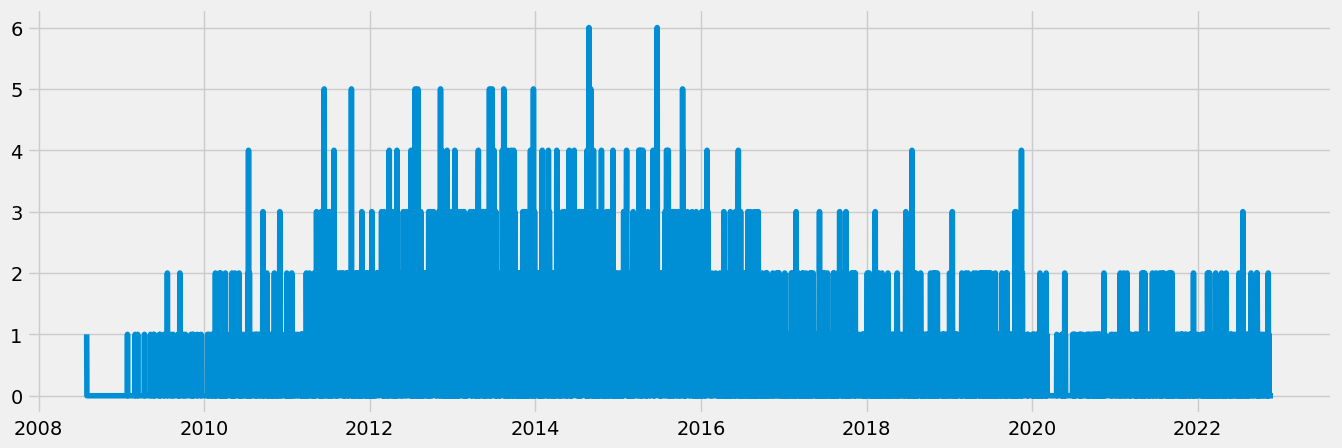

In [39]:
# Plotting the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_merged_1)

***6. Decomposing the Data***

In [40]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(df_merged_1, model='additive')

In [41]:
# Defining a fixed size for all special charts.

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

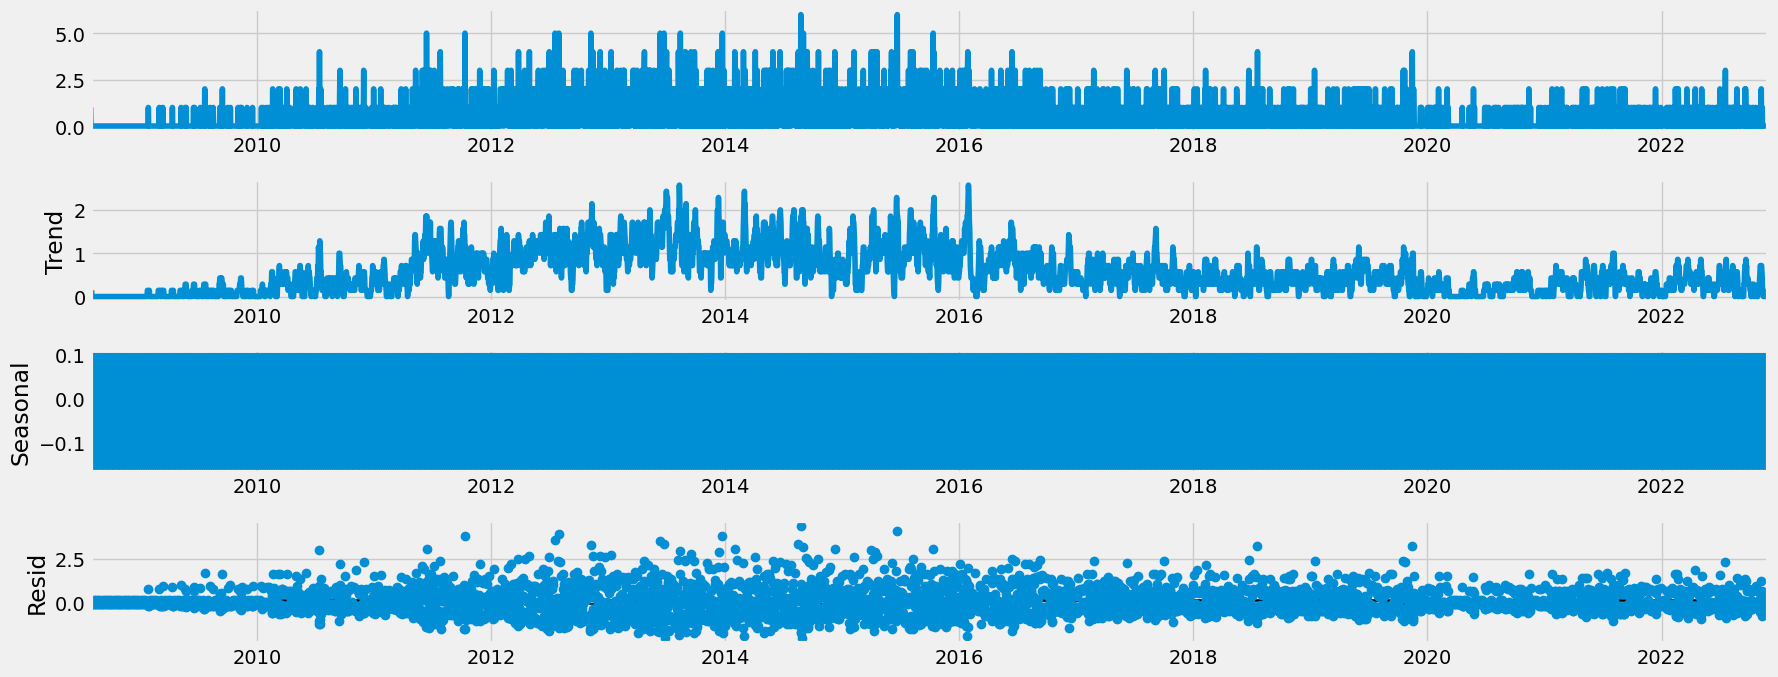

In [42]:
# Plotting the separate components

decomposition.plot()
plt.show()

***COMMENTS:***

Here I have a clearer view of the trend.

The seasonality is surprising, does it mean there is no seasonality?

Finally 'resid' showcases the noise, as expected the outliers show up here.

***7. Testing for Stationarity***

In [43]:
from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(df_merged_1['count_of_host'])

Dickey-Fuller Stationarity test:
Test Statistic                   -4.254591
p-value                           0.000532
Number of Lags Used              33.000000
Number of Observations Used    5201.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


***COMMENT:***

The test statistic (-4.03) is smaller than the critical value 5% (-2.86), this means I have to reject the null hypothesis.

This means that there isn't a unit root in the data, and the data is stationary (unexpected).

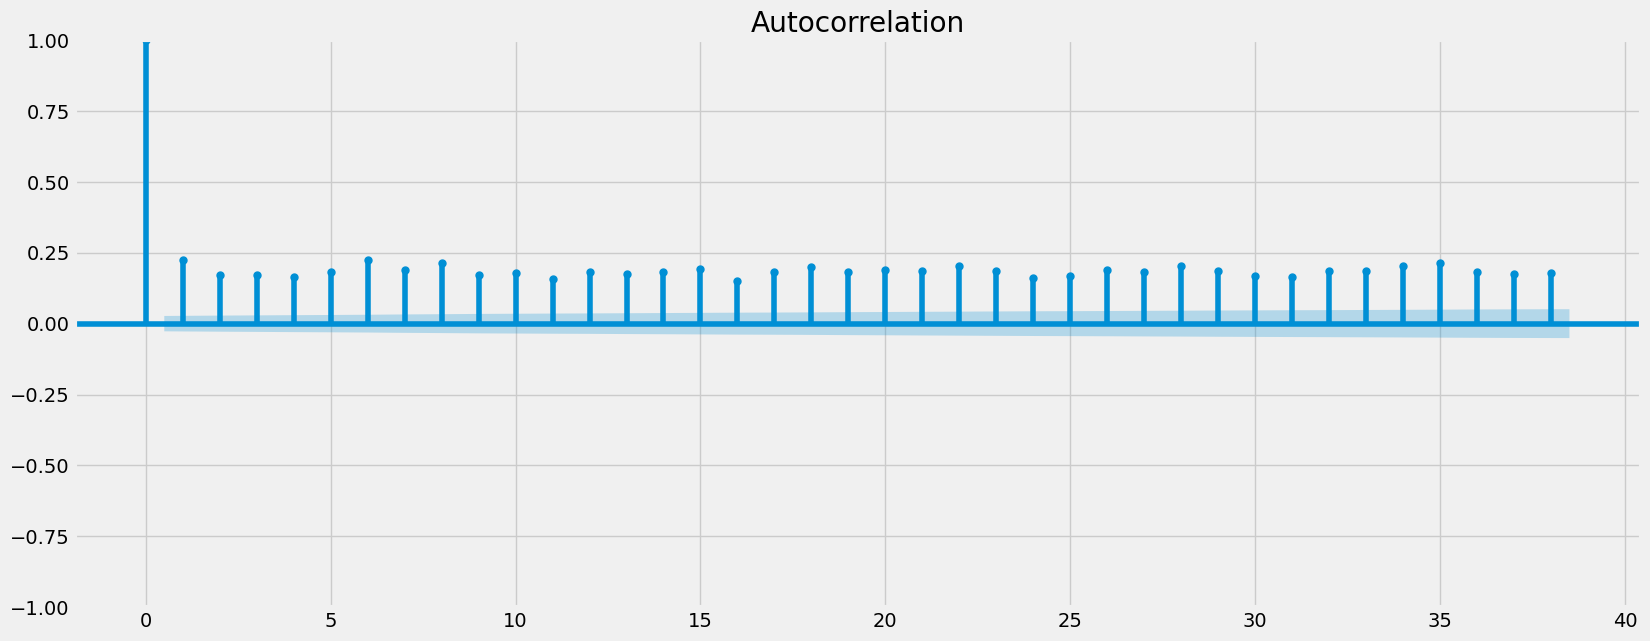

In [44]:
# Checking out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(df_merged_1)
plt.show()

# ***COMMENT:***

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. Because the lines go above the blue edge of the confidence interval, this means I have lags that are significantly correlated with each other. And because there are many lags beyond this interval, I can deduce that the data is non-stationary. This means that here there’s a lot of autocorrelated data and the set is likely non-stationary, which supports the result of the Dickey-Fuller test.

***8. Stationarizing the Data***

In [45]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff = df_merged_1 - df_merged_1.shift(1)

In [46]:
# Here, I remove the missing values that came about as a result of the differencing. 

data_diff.dropna(inplace = True)

In [47]:
data_diff.head()

,count_of_host
datetime,
2008-08-01,-1.0
2008-08-02,0.0
2008-08-03,0.0
2008-08-04,0.0
2008-08-05,0.0


In [48]:
data_diff.columns

Index(['count_of_host'], dtype='object')

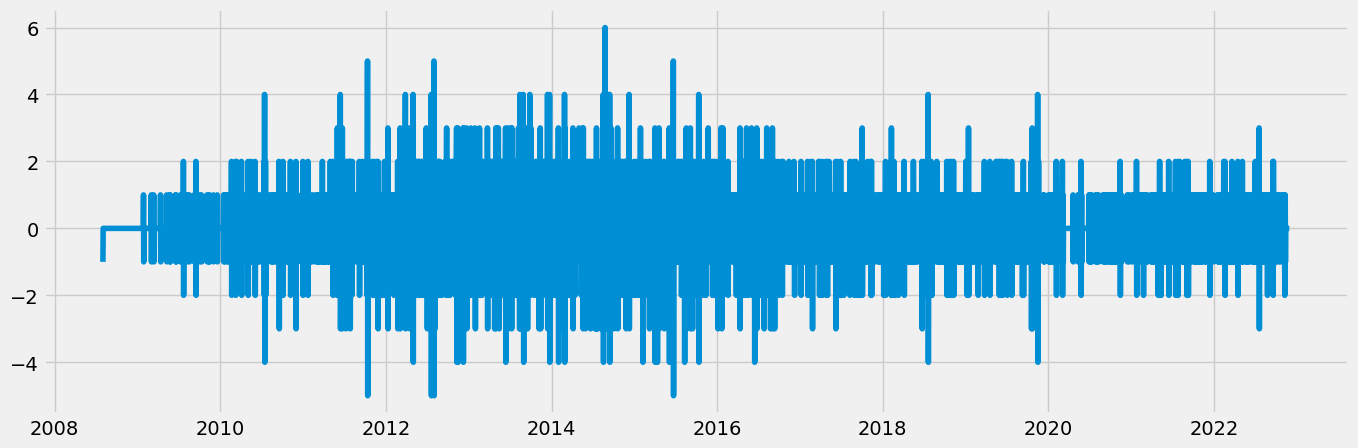

In [49]:
# Checking out what the differencing did to the time-series curve
# It looks very much stationary

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [50]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -22.382307
p-value                           0.000000
Number of Lags Used              33.000000
Number of Observations Used    5200.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


# ***COMMENT:***

The test statistic (-22.38) is now much smaller than the critical value 5% (-2.86), moreover the p-value is satisfactory (p<0.05), this mean I can reject the null hypothesis and consider my series stationary.

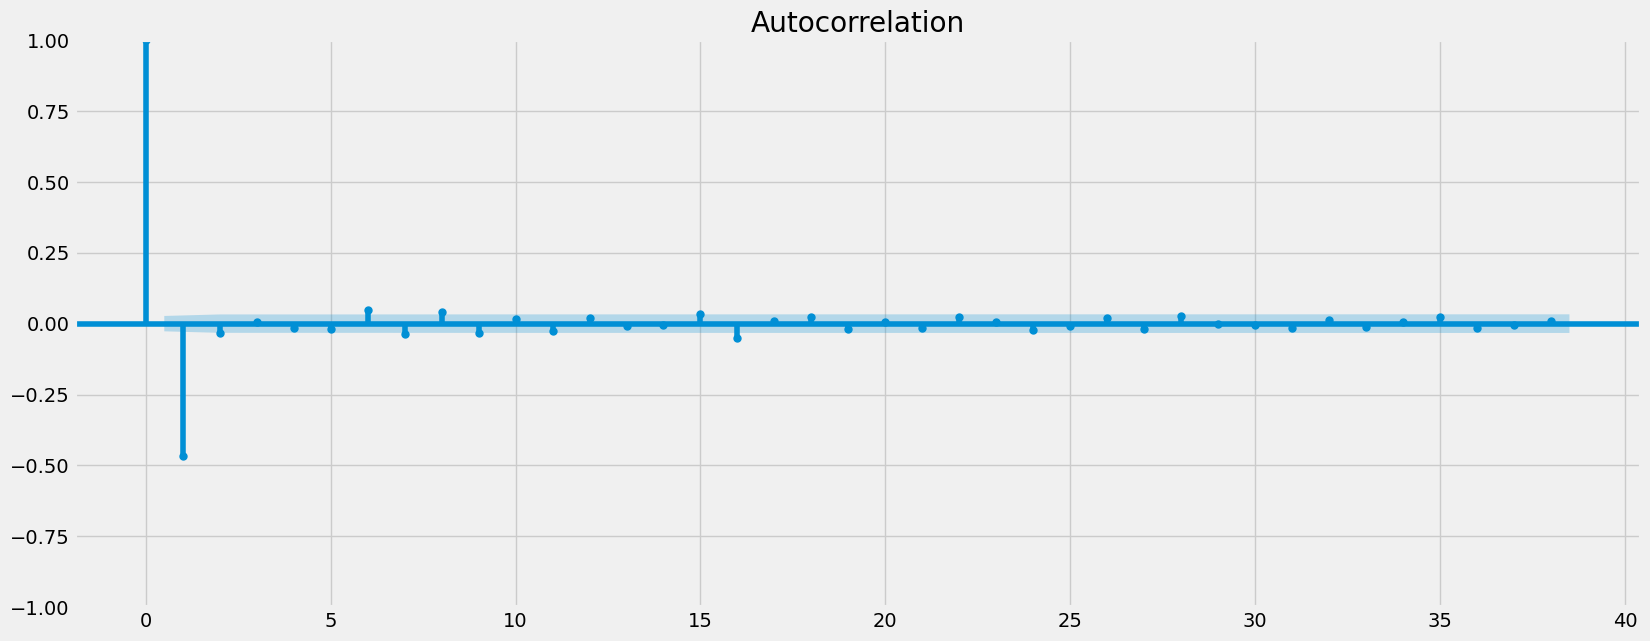

In [51]:
# Checking out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff)
plt.show()

# ***COMMENT:***

The auto-correlation plot has greatly improved (there are fewer autocorrelated terms). It is however difficult to count whether it's good enough (lags within confidence interval). The data is stationary but I'm not 100% sure it's stationary enough. I will conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms.

***9. Stationarizing the Data (second round)***

In [52]:
data_diff2 = data_diff - data_diff.shift(1)

In [53]:
data_diff2.dropna(inplace = True)

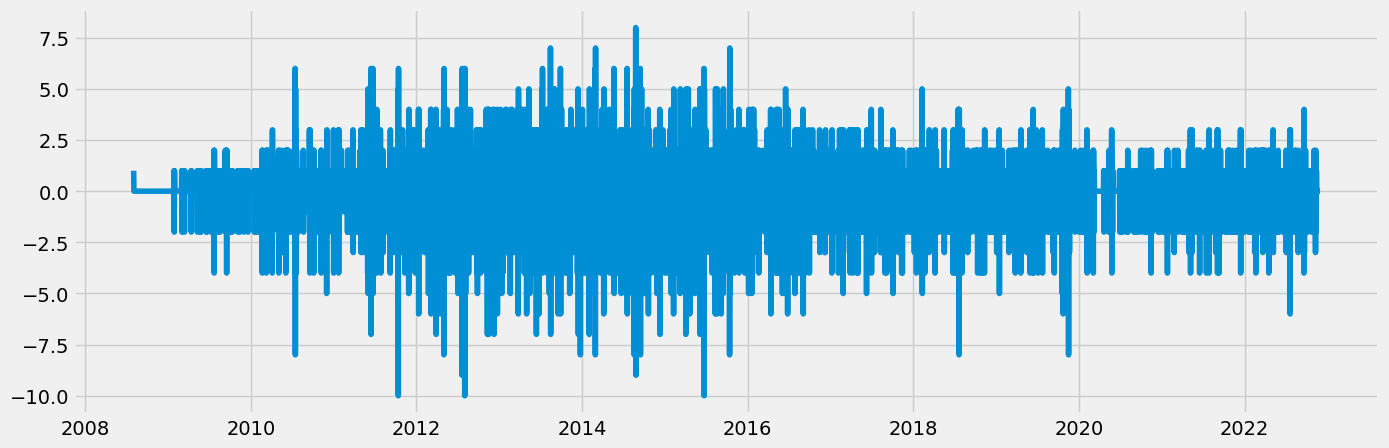

In [54]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [55]:
# The dickey fuller test presents even more conclusive results

dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                  -26.804813
p-value                           0.000000
Number of Lags Used              33.000000
Number of Observations Used    5199.000000
Critical Value (1%)              -3.431608
Critical Value (5%)              -2.862096
Critical Value (10%)             -2.567066
dtype: float64


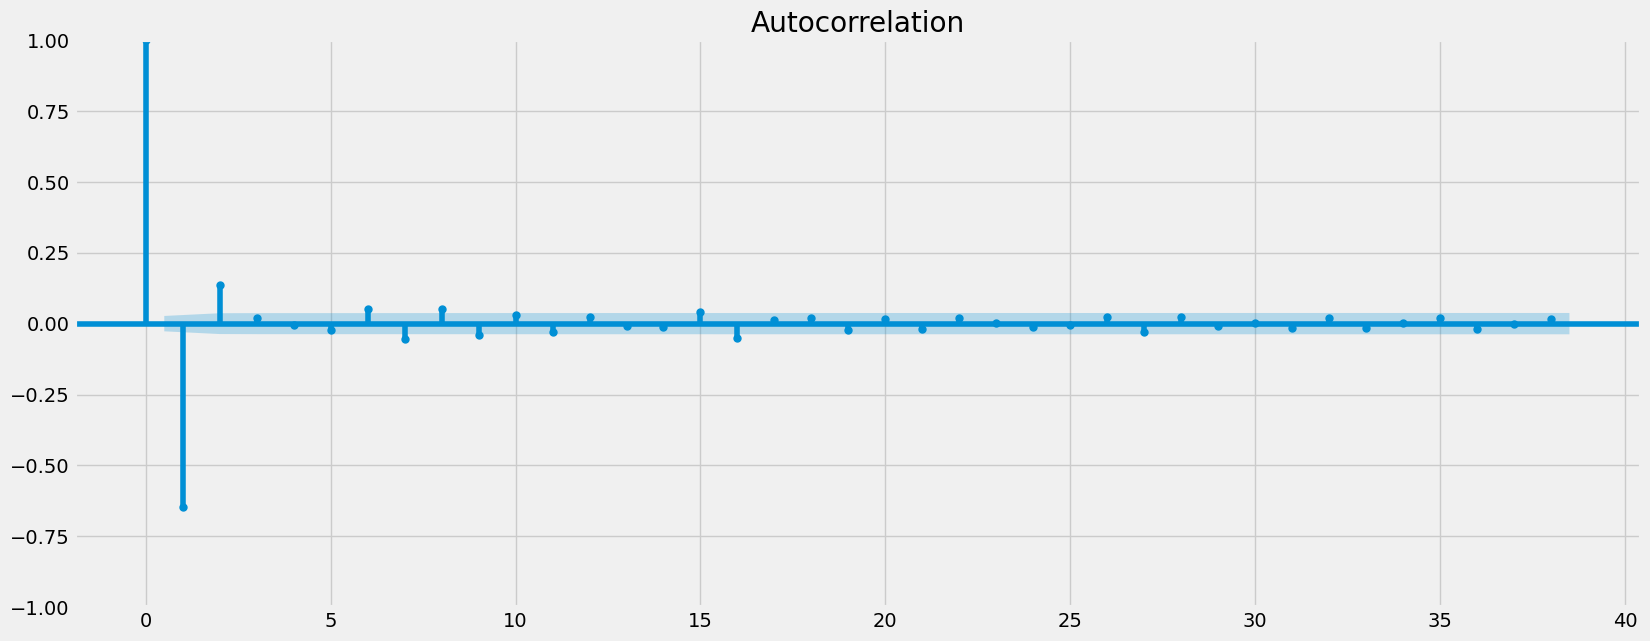

In [56]:
# Checking autocorrelations, the data is definitely stationary now

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_diff2)
plt.show()